
![alt text](http://gmum.net/images/logo.jpg =300x150)


---


# Workshop Overview: 


The workshop goal is to introduce a simple auto-encoder model and present solutions for dealing with missing data, including
the recently proposed method in (https://papers.nips.cc/paper/7537-processing-of-missing-data-by-neural-networks.pdf)  



1.   Read MNIST data
2.   Implement Classical auto-encoder
3.   Download MNIST images with missing values
4.   Inpaint missing values and feed them to an auto-encoder
5.   Our method
6.   MNIST classification


---






In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from tensorflow.keras.layers import Dense


%matplotlib inline

transform_write = {'blue': '\033[94m', 'green': '\033[92m', 'yellow': '\033[93m', 'red': '\033[91m', 'bold': '\033[1m', 'italic': '\x1B[3m', 'underline': '\033[4m', 'end': '\033[0m'}

<br>
<br>
<br>
### 1. Read MNIST data
Read the MNIST dataset. Preprocess it and reshape into vectors of dimension  `784`. 


---  


In [2]:
# Import data
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
# set the data to be in interval [0,1].
x_train, x_test = x_train / 255.0, x_test / 255.0
valid_length = len(y_test)//2;
x_valid = x_test[:valid_length]
y_valid = y_test[:valid_length]
x_test = x_test[valid_length:]
y_test = y_test[valid_length:]


print('Shape of train data: {}'.format(x_train.shape))
print('Shape of train labels: {}'.format(y_train.shape))
print('Shape of valid data: {}'.format(x_valid.shape))
print('Shape of valid labels: {}'.format(y_valid.shape))
print('Shape of test data: {}'.format(x_test.shape))
print('Shape of test labels: {}'.format(y_test.shape))

# resize to 784
x_train = x_train.reshape(-1, 784)
x_valid = x_valid.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# change background to white
x_train = 1. - x_train
x_test = 1. - x_test
x_valid = 1. - x_valid

11493376/11490434 [==============================] - 0s 0us/step
Shape of train data: (60000, 28, 28)
Shape of train labels: (60000,)
Shape of valid data: (5000, 28, 28)
Shape of valid labels: (5000,)
Shape of test data: (5000, 28, 28)
Shape of test labels: (5000,)


<br>
<br>
<br>
### 2. Classical auto-encoder

Build and train a classical auto-encoder model, as described by the hyperparameters and image below:
![](https://ww2.ii.uj.edu.pl/~z1101353/ae.png)


---



2.1. Set up the hyperparameters

In [0]:
# Training Parameters
learning_rate = 0.01
n_epochs = 50
batch_size = 64

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features 
num_hidden_3 = 64  # 3nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


2.2. Build the auto-encoder model graph, as described by the hyperparameters and image above. The architecture is a feed-forward network.


*   Ex 1. : Complete the code for the encoder. 
*   Ex 2. : Complete the code for the decoder
*   Ex 3. : Define the prediction. Be sure to pass the output of the encoder as the input to decoder.
*   Ex 4. : Define the loss (MSE) and the optimization operation.   Use the [`tf.train.RMSPropOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer). Be sure to pass the `learning_rate` to the optimizer's constructor.




In [0]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

def encoder(x):
    # Ex 1. : Complete the code for the encoder.
    layer_1 = Dense(num_hidden_1, activation="relu")(x)
    layer_2 = Dense(num_hidden_2, activation="sigmoid", bias_initializer="random_normal")(layer_1)
    layer_3 = Dense(num_hidden_3, activation="sigmoid", bias_initializer="random_normal")(layer_2)
    return layer_3

def decoder(x):
    # Ex 2. : Complete the code for the decoder.
    layer_1 = Dense(num_hidden_2, activation="sigmoid")(x)
    layer_2 = Dense(num_hidden_1, activation="sigmoid", bias_initializer="random_normal")(layer_1)
    layer_3 = Dense(num_input, activation="sigmoid", bias_initializer="random_normal")(layer_2)
    return layer_3

# Ex. 3. : Define the prediction
encoded = encoder(X)
decoded = decoder(encoded)
y_pred = decoded
y_true = X

# Ex. 4. : Define the loss and optimization operation
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

optimizer_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)



2.3.  Train the model

*   Ex.5: Define the train function for the model, with arguments:
 *   `sess` -  the open tf.Session. Assume the global variables have already been initialized.
 *   `x_train` - the train dataset.
 *   `x_valid` - the validation dataset. After each completed epoch you may evaluate and report the loss on the validation dataset, as a way to monitor the model performence on out-of-train data. 
 *   `batch_size` - the size of one batch.
 *   `n_epochs` - number of epochs 

After each epoch remember to shuffle the train dataset. 

If you want, you may use [`tqdm`](https://github.com/tqdm/tqdm) function for a nice progress bar, as in section 2.4. 






In [0]:
def train(sess, x_train, x_valid, batch_size, n_epochs):
    #Ex. 5: Define the train function
    for epoch in range(1, n_epochs + 1):
        #train
        n_batches = x_train.shape[0] // batch_size
        train_loss = []
        for iteration in tqdm(range(n_batches)):
            batch_x = x_train[iteration * batch_size : (iteration+1) * batch_size, :]
            _, l = sess.run([optimizer_op, loss], feed_dict={X: batch_x})
            train_loss.append(l)
            
        #valid
        valid_n_batches = x_valid.shape[0]//batch_size
        valid_loss = []
        for iteration in range(valid_n_batches):
            batch_valid_x = x_valid[iteration * batch_size : (iteration+1) * batch_size, :]
            valid_loss.append(sess.run(loss,feed_dict={X:batch_valid_x}))
        
        print('Step %i: Loss mean: %.8f Valid loss mean: %.8f' % (epoch, np.mean(train_loss), np.mean(valid_loss)))
        sys.stdout.flush()
        #shuffle the train dataset
        np.random.shuffle(x_train)
    print('\n==========================')
    

2.4. Evaluate the model.

The function below takes a tf.Session with a trained model, and runs the evaluation on test data.

In [0]:
def test(sess, x_test, batch_size):
    # calculate MSE between original test data and reconstruction of test data
    mse = 0.
    n_batches = x_test.shape[0] // batch_size
    for iteration in tqdm(range(n_batches)):
        batch_x = x_test[iteration * batch_size : (iteration+1)*batch_size, :]
        reconstruction = sess.run(decoded, feed_dict={X: batch_x})
        mse += np.mean(np.square(batch_x - reconstruction))
    mse = mse / n_batches

    print('Number of samples of test data: {:d}'.format(x_test.shape[0]))
    print('{}MSE between original test data and reconstruction of test data equals {}{:0.5f}{}'.format(transform_write['italic'], transform_write['bold'], mse, transform_write['end']))


2.5. Print the samples

The function below takes a tf.Session with a trained model, and samples random examples from test data, outputting the true and reconstructed images

In [0]:
def print_samples(sess, x_test):
    number_of_examples = 5  
    batch_x = x_test[np.random.choice(x_test.shape[0], number_of_examples, replace=False), :]
    reconstruction = sess.run(decoded, feed_dict={X: batch_x})

    # Display images
    for j in range(number_of_examples):
        # Draw the original digits
        _, ax = plt.subplots(1, 2, figsize=(4, 8))
        ax[0].imshow(batch_x[j].reshape([28, 28]), origin="upper", cmap="gray")
        ax[0].axis('off')
        ax[0].set_title('Original')

        # Draw the reconstruction digits
        ax[1].imshow(reconstruction[j].reshape([28, 28]), origin="upper", cmap="gray")
        ax[1].axis('off')
        ax[1].set_title('Reconstruction')

2.6. Run the code

Create a tf.Session and run the functions:

100%|██████████| 937/937 [00:03<00:00, 266.53it/s]


Step 1: Loss mean: 0.08247718 Valid loss mean: 0.06434163


100%|██████████| 937/937 [00:02<00:00, 334.36it/s]


Step 2: Loss mean: 0.05364893 Valid loss mean: 0.04600751


100%|██████████| 937/937 [00:02<00:00, 332.52it/s]


Step 3: Loss mean: 0.04242370 Valid loss mean: 0.03825483


100%|██████████| 937/937 [00:02<00:00, 334.01it/s]


Step 4: Loss mean: 0.03585906 Valid loss mean: 0.03336896


100%|██████████| 937/937 [00:02<00:00, 331.00it/s]


Step 5: Loss mean: 0.03273408 Valid loss mean: 0.03163806


100%|██████████| 937/937 [00:02<00:00, 330.46it/s]


Step 6: Loss mean: 0.03080888 Valid loss mean: 0.03249632


100%|██████████| 937/937 [00:02<00:00, 333.54it/s]


Step 7: Loss mean: 0.02947669 Valid loss mean: 0.03054215


100%|██████████| 937/937 [00:02<00:00, 333.57it/s]


Step 8: Loss mean: 0.02837673 Valid loss mean: 0.02797578


100%|██████████| 937/937 [00:02<00:00, 334.31it/s]


Step 9: Loss mean: 0.02757845 Valid loss mean: 0.02981289


100%|██████████| 937/937 [00:02<00:00, 332.52it/s]


Step 10: Loss mean: 0.02693274 Valid loss mean: 0.02707741


100%|██████████| 937/937 [00:02<00:00, 330.61it/s]


Step 11: Loss mean: 0.02622959 Valid loss mean: 0.02731029


100%|██████████| 937/937 [00:02<00:00, 330.71it/s]


Step 12: Loss mean: 0.02592067 Valid loss mean: 0.02526961


100%|██████████| 937/937 [00:02<00:00, 331.80it/s]


Step 13: Loss mean: 0.02530489 Valid loss mean: 0.02582361


100%|██████████| 937/937 [00:02<00:00, 330.11it/s]


Step 14: Loss mean: 0.02470812 Valid loss mean: 0.02610637


100%|██████████| 937/937 [00:02<00:00, 329.55it/s]


Step 15: Loss mean: 0.02427736 Valid loss mean: 0.02591412


100%|██████████| 937/937 [00:02<00:00, 330.04it/s]


Step 16: Loss mean: 0.02393389 Valid loss mean: 0.02303654


100%|██████████| 937/937 [00:02<00:00, 331.48it/s]


Step 17: Loss mean: 0.02340097 Valid loss mean: 0.02380016


100%|██████████| 937/937 [00:02<00:00, 333.59it/s]


Step 18: Loss mean: 0.02319927 Valid loss mean: 0.02391481


100%|██████████| 937/937 [00:02<00:00, 330.42it/s]


Step 19: Loss mean: 0.02309199 Valid loss mean: 0.02314316


100%|██████████| 937/937 [00:02<00:00, 330.76it/s]


Step 20: Loss mean: 0.02279868 Valid loss mean: 0.02288931


100%|██████████| 937/937 [00:02<00:00, 330.00it/s]


Step 21: Loss mean: 0.02248961 Valid loss mean: 0.02536673


100%|██████████| 937/937 [00:02<00:00, 329.55it/s]


Step 22: Loss mean: 0.02238671 Valid loss mean: 0.02403140


100%|██████████| 937/937 [00:02<00:00, 332.93it/s]


Step 23: Loss mean: 0.02228862 Valid loss mean: 0.02305679


100%|██████████| 937/937 [00:02<00:00, 330.11it/s]


Step 24: Loss mean: 0.02217229 Valid loss mean: 0.02228759


100%|██████████| 937/937 [00:02<00:00, 334.18it/s]


Step 25: Loss mean: 0.02204361 Valid loss mean: 0.02188036


100%|██████████| 937/937 [00:02<00:00, 333.89it/s]


Step 26: Loss mean: 0.02206421 Valid loss mean: 0.02237081


100%|██████████| 937/937 [00:02<00:00, 332.48it/s]


Step 27: Loss mean: 0.02178936 Valid loss mean: 0.02188420


100%|██████████| 937/937 [00:02<00:00, 332.97it/s]


Step 28: Loss mean: 0.02149935 Valid loss mean: 0.02171838


100%|██████████| 937/937 [00:02<00:00, 330.76it/s]


Step 29: Loss mean: 0.02136881 Valid loss mean: 0.02130066


100%|██████████| 937/937 [00:02<00:00, 334.17it/s]


Step 30: Loss mean: 0.02118269 Valid loss mean: 0.02148863


100%|██████████| 937/937 [00:02<00:00, 332.21it/s]


Step 31: Loss mean: 0.02103731 Valid loss mean: 0.02150935


100%|██████████| 937/937 [00:02<00:00, 331.93it/s]


Step 32: Loss mean: 0.02108447 Valid loss mean: 0.02303789


100%|██████████| 937/937 [00:02<00:00, 332.88it/s]


Step 33: Loss mean: 0.02086032 Valid loss mean: 0.02124875


100%|██████████| 937/937 [00:02<00:00, 332.86it/s]


Step 34: Loss mean: 0.02081298 Valid loss mean: 0.02067977


100%|██████████| 937/937 [00:02<00:00, 332.47it/s]


Step 35: Loss mean: 0.02066405 Valid loss mean: 0.02107072


100%|██████████| 937/937 [00:02<00:00, 319.78it/s]


Step 36: Loss mean: 0.02076451 Valid loss mean: 0.02098430


100%|██████████| 937/937 [00:02<00:00, 315.54it/s]


Step 37: Loss mean: 0.02055124 Valid loss mean: 0.02140066


100%|██████████| 937/937 [00:02<00:00, 314.95it/s]


Step 38: Loss mean: 0.02030645 Valid loss mean: 0.02077129


100%|██████████| 937/937 [00:02<00:00, 323.97it/s]


Step 39: Loss mean: 0.02016104 Valid loss mean: 0.02070235


100%|██████████| 937/937 [00:02<00:00, 332.45it/s]


Step 40: Loss mean: 0.02027807 Valid loss mean: 0.02114969


100%|██████████| 937/937 [00:02<00:00, 333.13it/s]


Step 41: Loss mean: 0.02007229 Valid loss mean: 0.01983742


100%|██████████| 937/937 [00:02<00:00, 331.60it/s]


Step 42: Loss mean: 0.02019572 Valid loss mean: 0.01977859


100%|██████████| 937/937 [00:02<00:00, 331.94it/s]


Step 43: Loss mean: 0.01993522 Valid loss mean: 0.02029860


100%|██████████| 937/937 [00:02<00:00, 332.44it/s]


Step 44: Loss mean: 0.01976936 Valid loss mean: 0.02068002


100%|██████████| 937/937 [00:02<00:00, 330.80it/s]


Step 45: Loss mean: 0.01966465 Valid loss mean: 0.02028649


100%|██████████| 937/937 [00:02<00:00, 331.62it/s]


Step 46: Loss mean: 0.01976966 Valid loss mean: 0.02057564


100%|██████████| 937/937 [00:02<00:00, 332.05it/s]


Step 47: Loss mean: 0.01965631 Valid loss mean: 0.02014323


100%|██████████| 937/937 [00:02<00:00, 330.60it/s]


Step 48: Loss mean: 0.01959291 Valid loss mean: 0.01994776


100%|██████████| 937/937 [00:02<00:00, 332.71it/s]


Step 49: Loss mean: 0.01946531 Valid loss mean: 0.01990951


100%|██████████| 937/937 [00:02<00:00, 331.48it/s]


Step 50: Loss mean: 0.01936342 Valid loss mean: 0.01974584



100%|██████████| 78/78 [00:00<00:00, 441.48it/s]

Number of samples of test data: 5000


MSE between original test data and reconstruction of test data equals 0.01895


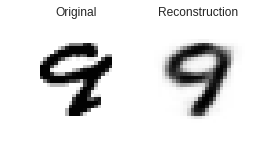

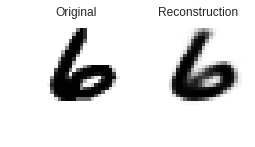

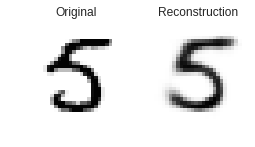

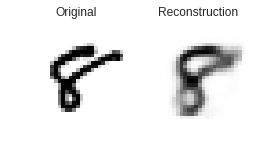

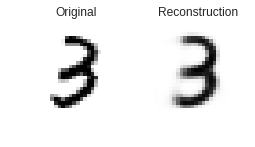

In [8]:
# Get the global varaibles initializer
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # initialize the varaibles
    sess.run(init)
    # train
    train(sess, np.copy(x_train), x_valid, batch_size, n_epochs)
    # evaluate
    test(sess, x_test, batch_size)
    # display samples from test
    print_samples(sess, x_test)
    

<br>
<br>
<br>
### 3. Download missing MNIST images
Prepare the missing images. If you have already downloaded the data, you can use the code below to upload it. If you would like to upload the .zip file, rememebr to unpack it using:  
`!unzip -o missing.zip`




---



In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

If you haven't downloaded the data yet, you may do it now, or just run the cell below (do whatever will be faster for you)

In [10]:
# Download the data with missing values
!wget -nc https://ww2.ii.uj.edu.pl/~z1101353/missing.zip
!unzip -o missing.zip

--2018-12-17 11:08:49--  https://ww2.ii.uj.edu.pl/~z1101353/missing.zip
Resolving ww2.ii.uj.edu.pl (ww2.ii.uj.edu.pl)... 149.156.65.36
Connecting to ww2.ii.uj.edu.pl (ww2.ii.uj.edu.pl)|149.156.65.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17112206 (16M) [application/zip]
Saving to: ‘missing.zip’

missing.zip         100%[===================>]  16.32M  8.37MB/s    in 1.9s    

2018-12-17 11:08:51 (8.37 MB/s) - ‘missing.zip’ saved [17112206/17112206]

Archive:  missing.zip
  inflating: missing_test.npy        
  inflating: missing_train.npy       
  inflating: missing_valid.npy       


Now load the data from the files. 

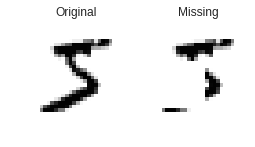

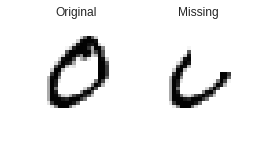

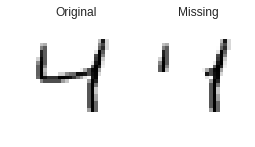

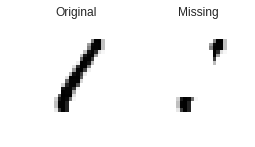

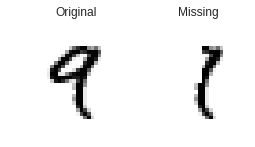

In [11]:
#Load the data
train_data = np.load("missing_train.npy")
valid_data = np.load("missing_valid.npy")
test_data = np.load("missing_test.npy")

number_of_examples = 5

# Display images
for i in range(number_of_examples):
    _, ax = plt.subplots(1, 2, figsize=(4, 8))
    ax[0].imshow(x_train[i].reshape([28, 28]), origin="upper", cmap="gray")
    ax[0].axis('off')
    ax[0].set_title("Original")
    
    ax[1].imshow(train_data[i].reshape([28, 28]), origin="upper", cmap="gray")
    ax[1].axis('off')
    ax[1].set_title("Missing")

### 4. Inpaint missing values and feed them to Auto-Encoder

**Problem description:**

Assume you have a dataset which lacks some values in the attributes. Consider for example the above MNSIT dataset with removed square parts. How to process such data through a network? 

A possible solution to this problem is imputing the missing values. This can be done either using simple heuristics: i.e. by replacing the NaN values with a constant, or with the median/mean of the given attribute. Other approach is to build a network that directly predicts the missing values (note, however,  that this requires the access to full, non-missing data for training). 

In this exercise you will be asked to solve the above problem with an auto-encoder. We will impute the NaNs with the attribute mean and feed them to the model. A possible intuition is that minimizing the reconstruction loss against different examples of the same digit may help the auto-encoder to place them “near” each other in the latent dim regardless the missing parts, and decode them to a better representation. 


---




4.1. Set up parameters

In [0]:
#Training Parameters
learning_rate = 0.01
n_epochs = 50
batch_size = 64

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 256 # 2nd layer num features (the latent dim)
num_hidden_3 = 64  # 128 # 3nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)

4.2.  Create the model

*   Ex. 6: Define the model and the prediction. You may use the encoder and decoder functions from Ex.1. and Ex.2. 
*   Ex. 7: Define the loss (MSE between prediction and X_orig) and the optimization operation. Again, use [`tf.train.RMSPropOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer). Be sure to consider only the non-missing point's in the calculation of the loss function. You may find [`tf.is_nan`](https://www.tensorflow.org/api_docs/python/tf/debugging/is_nan) and [`tf.where`](https://www.tensorflow.org/api_docs/python/tf/where) useful for this task. 
*  Ex. 8: Create and fit the [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) model from `sklearn` package. Missing values are indicated as `NaN`. Use the `mean` strategy.


In [13]:
from sklearn.impute import SimpleImputer  # used to input missing values

# tf Graph input (only pictures).
# X is the placeholder for the input data, which will be inpainted using 
# a classical method from sklearn, before being fed to the model.  
X = tf.placeholder("float", [None, num_input])
X_orig = tf.placeholder("float", [None, num_input])

# Ex. 6: Define the model and the prediction
encoded = encoder(X)
decoded = decoder(encoded)
y_pred = decoded
y_true = X_orig


# Ex. 7: Define the loss and the optimization operation
# Get the position where the values are missing
# set them to zeros
where_isnan = tf.is_nan(y_true)
y_pred = tf.where(where_isnan, tf.zeros_like(y_pred), y_pred)
y_true = tf.where(where_isnan, tf.zeros_like(y_true), y_true)

# Define loss and optimizer, minimize the mean square error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Ex. 8: Create and fit the imputer
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(train_data)



SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)

4.3. Train the model

*   Ex. 9: Define the train function for the model, with arguments:
 *   `sess` -  the open tf.Session. Assume the global variables have already been initialized.
 *   `x_train` - the train dataset.
 *   `x_valid` - the validation dataset. After each completed epoch you may evaluate and report the loss on the validation dataset, as a way to monitor the model performence on out-of-train data. 
 *   `batch_size` - the size of one batch.
 *   `n_epochs` - number of epochs 
 *   `imp` - the imputer model from `sklearn`. Use the `transform` method to input the values.
 
 Note that this function will be almost identical to the one from Ex. 5. The only difference is that you have to impute the values of input data using the  Imputer `imp` befor feeding them to the network. 

In [0]:
def train(sess, train_data, valid_data, batch_size, n_epochs, imp):
    #Ex. 9: Create the train function
    for epoch in range(1, n_epochs + 1):
        
        #train
        n_batches = train_data.shape[0] // batch_size
        train_loss = []
        for iteration in tqdm(range(n_batches)):
            # get the train batch
            batch_x = train_data[iteration * batch_size : (iteration+1) * batch_size, :]
             # input the values
            batch_x_mean = imp.transform(batch_x)
            
            _, l = sess.run([optimizer_op, loss],  feed_dict={X: batch_x_mean, X_orig: batch_x})
            train_loss.append(l)
            
        #valid
        valid_n_batches = valid_data.shape[0]//batch_size
        valid_loss = []
        for iteration in range(valid_n_batches):
            batch_valid_x = valid_data[iteration * batch_size : (iteration+1) * batch_size, :]
            batch_valid_x_mean = imp.transform(batch_valid_x)
            valid_loss.append(sess.run(loss,  feed_dict={X: batch_valid_x_mean, X_orig: batch_valid_x}))
        print('Step %i: Loss mean: %.8f Valid loss mean: %.8f' % (epoch, np.mean(train_loss), np.mean(valid_loss)))
        sys.stdout.flush()
        #shuffle the train dataset
        np.random.shuffle(train_data)
    print('\n==========================')
   

4.4. Evaluate the model

This function takes a tf.Session with a trained model, a dataset of non-missing values (x_test), the corresponding missing test dataset (test_data), the batch size and the imputer `imp`. It calculates the reconstruction (MSE) error between the model outputs and the true (non-missing) images.

In [0]:
def test(sess, x_test, test_data, batch_size, imp):
    assert len(x_test)==len(test_data)
    # calculate MSE between original test data and reconstruction of test data
    mse = 0.
    mse_inside_nan = 0
    # test
    n_batches = test_data.shape[0] // batch_size
    for iteration in tqdm(range(n_batches)):
        batch_x = test_data[iteration * batch_size : (iteration+1)*batch_size, :]
        batch_orig = x_test[iteration * batch_size : (iteration+1)*batch_size, :]
        isfinite = np.isfinite(batch_x)
        batch_x = imp.transform(batch_x)
        
        reconstruction = sess.run(decoded, feed_dict={X: batch_x})
        mse += np.mean(np.square(batch_orig - reconstruction))
        batch_orig[isfinite] = 0.
        reconstruction[isfinite] = 0.
        mse_inside_nan += np.mean(np.square(batch_orig - reconstruction))
        
    mse = mse / n_batches
    mse_inside_nan = mse_inside_nan / n_batches
    print('Number of samples of test data: {:d}'.format(x_test.shape[0]))
    print('{}MSE between full test images and the reconstruction obtained from the missing data: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['bold'], mse, transform_write['end']))
    print('{}MSE between full test images and the reconstruction obtained from the missing data on the area where the values were missing: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['red'] + transform_write['bold'], mse_inside_nan, transform_write['end']))
    print('{}MSE between full test images and the reconstruction obtained from the missing data on the area where the values were not missing: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['blue'] + transform_write['bold'], mse - mse_inside_nan, transform_write['end']))
        


4.5. Print the samples.

This function takes a tf.Session and outputs samples from the non-missing test dataset, the corresponding missing images, the result of imputation with the mean and the reconstractions obtained by the trained model. 

In [0]:
def print_samples(sess, x_test, test_data, batch_size, imp):
    number_of_samples = 5  
    # MNIST test set
    idx = np.random.choice(test_data.shape[0], number_of_samples, replace=False)
    
    # original image
    batch_orig = x_test[idx]
    # image with missing values
    batch_x = test_data[idx, :]
    # image with filled with mean
    batch_x_input = imp.transform(batch_x)
    # reconstructed image
    reconstruction = sess.run(decoded, feed_dict={X: batch_x_input})
    

    # Display images
    for i in range(number_of_samples):
        # Draw the original digits
        _, ax = plt.subplots(1, 4, figsize=(4, 16))
        ax[0].imshow(batch_orig[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[0].axis('off')
        ax[0].set_title("Original")
        
        # Draw the digits with missing 
        ax[1].imshow(batch_x[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[1].axis('off')
        ax[1].set_title("Missing")
        
        # Draw the input mean/knn digits
        ax[2].imshow(batch_x_input[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[2].axis('off')
        ax[2].set_title("Imputed using mean")
            
        # Draw the reconstruction digits
        ax[3].imshow(reconstruction[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[3].axis('off')
        ax[3].set_title("Reconstructed")

4.6. Run the model

Run the functions:

100%|██████████| 937/937 [00:04<00:00, 231.37it/s]


Step 1: Loss mean: 0.05554793 Valid loss mean: 0.03754926


100%|██████████| 937/937 [00:03<00:00, 235.31it/s]


Step 2: Loss mean: 0.03608196 Valid loss mean: 0.03571694


100%|██████████| 937/937 [00:03<00:00, 237.47it/s]


Step 3: Loss mean: 0.03383885 Valid loss mean: 0.03043639


100%|██████████| 937/937 [00:03<00:00, 236.67it/s]


Step 4: Loss mean: 0.03134502 Valid loss mean: 0.02840797


100%|██████████| 937/937 [00:03<00:00, 236.34it/s]


Step 5: Loss mean: 0.02851960 Valid loss mean: 0.02658832


100%|██████████| 937/937 [00:03<00:00, 236.97it/s]


Step 6: Loss mean: 0.02680065 Valid loss mean: 0.02560763


100%|██████████| 937/937 [00:03<00:00, 234.80it/s]


Step 7: Loss mean: 0.02578934 Valid loss mean: 0.02521646


100%|██████████| 937/937 [00:03<00:00, 235.71it/s]


Step 8: Loss mean: 0.02519274 Valid loss mean: 0.02513347


100%|██████████| 937/937 [00:03<00:00, 235.72it/s]


Step 9: Loss mean: 0.02479465 Valid loss mean: 0.02551084


100%|██████████| 937/937 [00:03<00:00, 236.24it/s]


Step 10: Loss mean: 0.02452308 Valid loss mean: 0.02628119


100%|██████████| 937/937 [00:03<00:00, 236.12it/s]


Step 11: Loss mean: 0.02431578 Valid loss mean: 0.02345664


100%|██████████| 937/937 [00:04<00:00, 232.31it/s]


Step 12: Loss mean: 0.02411571 Valid loss mean: 0.02296882


100%|██████████| 937/937 [00:04<00:00, 227.35it/s]


Step 13: Loss mean: 0.02396149 Valid loss mean: 0.02252456


100%|██████████| 937/937 [00:03<00:00, 236.45it/s]


Step 14: Loss mean: 0.02385584 Valid loss mean: 0.02270411


100%|██████████| 937/937 [00:03<00:00, 234.61it/s]


Step 15: Loss mean: 0.02372565 Valid loss mean: 0.02357209


100%|██████████| 937/937 [00:03<00:00, 236.59it/s]


Step 16: Loss mean: 0.02366151 Valid loss mean: 0.02340380


100%|██████████| 937/937 [00:03<00:00, 237.38it/s]


Step 17: Loss mean: 0.02354471 Valid loss mean: 0.02264350


100%|██████████| 937/937 [00:03<00:00, 236.86it/s]


Step 18: Loss mean: 0.02348806 Valid loss mean: 0.02390961


100%|██████████| 937/937 [00:03<00:00, 236.15it/s]


Step 19: Loss mean: 0.02340635 Valid loss mean: 0.02314572


100%|██████████| 937/937 [00:03<00:00, 235.99it/s]


Step 20: Loss mean: 0.02334545 Valid loss mean: 0.02239102


100%|██████████| 937/937 [00:03<00:00, 235.67it/s]


Step 21: Loss mean: 0.02324642 Valid loss mean: 0.02464196


100%|██████████| 937/937 [00:03<00:00, 236.56it/s]


Step 22: Loss mean: 0.02322096 Valid loss mean: 0.02244200


100%|██████████| 937/937 [00:03<00:00, 235.79it/s]


Step 23: Loss mean: 0.02316091 Valid loss mean: 0.02483873


100%|██████████| 937/937 [00:03<00:00, 235.99it/s]


Step 24: Loss mean: 0.02312243 Valid loss mean: 0.02240095


100%|██████████| 937/937 [00:03<00:00, 235.62it/s]


Step 25: Loss mean: 0.02312856 Valid loss mean: 0.02259229


100%|██████████| 937/937 [00:03<00:00, 235.96it/s]


Step 26: Loss mean: 0.02307613 Valid loss mean: 0.02347380


100%|██████████| 937/937 [00:03<00:00, 236.66it/s]


Step 27: Loss mean: 0.02301919 Valid loss mean: 0.02276277


100%|██████████| 937/937 [00:03<00:00, 236.39it/s]


Step 28: Loss mean: 0.02299778 Valid loss mean: 0.02253428


100%|██████████| 937/937 [00:03<00:00, 234.84it/s]


Step 29: Loss mean: 0.02297150 Valid loss mean: 0.02366961


100%|██████████| 937/937 [00:03<00:00, 236.92it/s]


Step 30: Loss mean: 0.02294736 Valid loss mean: 0.02466607


100%|██████████| 937/937 [00:03<00:00, 236.33it/s]


Step 31: Loss mean: 0.02292409 Valid loss mean: 0.02255004


100%|██████████| 937/937 [00:03<00:00, 236.33it/s]


Step 32: Loss mean: 0.02286036 Valid loss mean: 0.02264459


100%|██████████| 937/937 [00:03<00:00, 237.17it/s]


Step 33: Loss mean: 0.02286400 Valid loss mean: 0.02330288


100%|██████████| 937/937 [00:03<00:00, 237.27it/s]


Step 34: Loss mean: 0.02285214 Valid loss mean: 0.02362422


100%|██████████| 937/937 [00:03<00:00, 237.33it/s]


Step 35: Loss mean: 0.02281250 Valid loss mean: 0.02334845


100%|██████████| 937/937 [00:03<00:00, 235.57it/s]


Step 36: Loss mean: 0.02279525 Valid loss mean: 0.02300777


100%|██████████| 937/937 [00:03<00:00, 236.24it/s]


Step 37: Loss mean: 0.02284108 Valid loss mean: 0.02221990


100%|██████████| 937/937 [00:03<00:00, 237.12it/s]


Step 38: Loss mean: 0.02276175 Valid loss mean: 0.02257000


100%|██████████| 937/937 [00:03<00:00, 235.60it/s]


Step 39: Loss mean: 0.02270809 Valid loss mean: 0.02219771


100%|██████████| 937/937 [00:03<00:00, 236.13it/s]


Step 40: Loss mean: 0.02267098 Valid loss mean: 0.02288250


100%|██████████| 937/937 [00:03<00:00, 237.10it/s]


Step 41: Loss mean: 0.02269654 Valid loss mean: 0.02241340


100%|██████████| 937/937 [00:03<00:00, 236.74it/s]


Step 42: Loss mean: 0.02264514 Valid loss mean: 0.02229772


100%|██████████| 937/937 [00:03<00:00, 236.91it/s]


Step 43: Loss mean: 0.02267268 Valid loss mean: 0.02252579


100%|██████████| 937/937 [00:04<00:00, 227.12it/s]


Step 44: Loss mean: 0.02264379 Valid loss mean: 0.02234970


100%|██████████| 937/937 [00:04<00:00, 225.66it/s]


Step 45: Loss mean: 0.02263748 Valid loss mean: 0.02298470


100%|██████████| 937/937 [00:04<00:00, 231.85it/s]


Step 46: Loss mean: 0.02259272 Valid loss mean: 0.02215634


100%|██████████| 937/937 [00:03<00:00, 236.62it/s]


Step 47: Loss mean: 0.02261018 Valid loss mean: 0.02248490


100%|██████████| 937/937 [00:03<00:00, 236.64it/s]


Step 48: Loss mean: 0.02257438 Valid loss mean: 0.02379410


100%|██████████| 937/937 [00:03<00:00, 236.35it/s]


Step 49: Loss mean: 0.02260578 Valid loss mean: 0.02342388


100%|██████████| 937/937 [00:03<00:00, 235.81it/s]


Step 50: Loss mean: 0.02259462 Valid loss mean: 0.02262291



100%|██████████| 78/78 [00:00<00:00, 296.90it/s]


Number of samples of test data: 5000
MSE between full test images and the reconstruction obtained from the missing data: 0.04406
MSE between full test images and the reconstruction obtained from the missing data on the area where the values were missing: 0.02136
MSE between full test images and the reconstruction obtained from the missing data on the area where the values were not missing: 0.02270


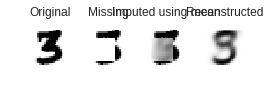

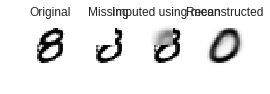

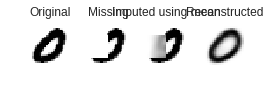

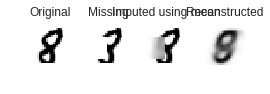

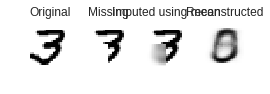

In [21]:
# Initialize the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    train(sess, np.copy(train_data), valid_data, batch_size, n_epochs, imp)
    test(sess, np.copy(x_test), test_data, batch_size, imp)
    print_samples(sess, x_test, test_data, batch_size, imp)
    

                  

<br>
<br>
<br>

$\newcommand{\R}[]{\mathbb{R}}$

### 5. Simple example of our method

Problem description (Recall from the lecture):

Let’s go back to the question how to process missing data through a network? The method proposed in https://papers.nips.cc/paper/7537-processing-of-missing-data-by-neural-networks modifies only the first layer of the network, by replacing the typical neuron’s response by its expected value. 

Assume that the missing values come from a (joint) probability distribution $F$.  For a given sample $[x, J]$ (where $x \in \R^D$, and  $J \subset \{1... D\}$ indicates the indicies where the values are misssing), we can define  an affine subspace $S = x + span(e_J).$  


---



**Example:**

$D=2$.  A missing point $[x, \{2\}]$ (which simply means $x = [x_1, NaN]$) defines a subspace $S$, which is a vertical line passing through $x_1$.


---



We can restrict the joint distribution $F$ to the affine subspace $S$, obtaining the (marginal) distribution $F_S(X)$:
<br>
<br>
\begin{equation}
\tag{1}
F_S(x) := \left\{
	\begin{array}{ll}
		\frac{F(x)}{\int_S{F(s)ds}}  &  x \in S \\
		0 & x \notin S
	\end{array}
\right.
\end{equation}

<br>
<br>

Now, for given $[x,J]$ we can compute the expected response of the first layer on $x \in S$ and pass it to the subsequent layers. The remaining network architecture does not change. 



---



The only question is, how to we get $F$ and $F_S$ and how to compute the expected response? 

Assume the following:
<br>
<br>
\begin{equation}
\ \tag{2}
F(x) := \sum_i{p_iN(m_i,\Sigma_i)}
\ 
\end{equation}
<br>
<br>

This means that $F$ can be represented as a mixture of Gaussians distributions. All $p_i$, $m_i$ and $\Sigma_i$ are trained together with the model weights. For such $F$ the $F_S$ can be represented as:
<br>
<br>
\begin{equation}
\ \tag{3}
F_S(x) := \sum_i{p_iN(m_{i,S},\Sigma_{i,S})},
\ 
\end{equation} 
\begin{equation}
\ 
m_{i,S} := [x_{J'}, m_{i,J}] \\
\Sigma_{i,S} := [0_{\{J',J'\}}, \Sigma_{i,\{J,J\}}]
\ 
\end{equation} 
where $J'= \{1..D\} -J$
<br>
<br>

Using the above, the expected ReLU activation of a neuron $x$, can be computed as:
 
<br>
<br>
\begin{equation}
E(ReLU_{w,b}(F_S)) =  \sum_i{p_i,NR(\frac{w^Tm_{i,S}+b}{\sqrt{w^T\Sigma_{i,S}w}})} 
\tag{4}
\end{equation}
<br>
<br>
with $NR(z) = \frac{1}{\sqrt{2\pi}}\exp{\frac{-z^2}{2}}+\frac{z}{2}(1+erf{\frac{z}{\sqrt{2}}})$

**Therefore the goal of the first layer is to compute (4) for each sample. **

---



5.1. Set up the hyperparameters

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture

# Training Parameters
learning_rate = 0.01
n_epochs = 50
batch_size = 64

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 256 # 2nd layer num features (the latent dim)
num_hidden_3 = 64  # 128 # 3nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)

n_distribution = 3  # number of Gaussian distributions


5.2  Ex. 10: Define the $NR$ function:  
 $NR(z) = \frac{1}{\sqrt{2\pi}}\exp{\frac{-z^2}{2}}+\frac{z}{2}(1+erf{\frac{z}{\sqrt{2}}})$



In [0]:
#Ex. 10: the NR function
def nr(w):
    return tf.div(tf.exp(tf.div(-tf.pow(w, 2), 2.)), np.sqrt(2 * np.pi)) + tf.multiply(tf.div(w, 2.), 1 + tf.erf(
        tf.div(w, np.sqrt(2))))

5.3. Write the code for the first layer

Ex. 11: Write the missing parts of the function `first_layer`, where:


*   `x` is the placeholder for inputs
*   `means` are the means  ($m_i$) of the Gaussians in `F` density - recall (2)
*   `covs` are the covariances ($\Sigma_i$) of the Gaussians in `F` density - recall (2)
*    `p` are the weights of the Gaussian Mixture - recall(2).   
All `means`, `covs`, `p` are `tf.Variables` and will be trained jointly with other model parameters. Assume that the covarainces are diagonal.

The function divides the batch into non-missing and missing sets (lines 8-11). The full data can be processed as usual (line 14). You are asked to complete the implementation of the computation of the expected value:
\begin{equation}
E(ReLU_{w,b}(F_S)) =  \sum_i{p_i,NR(\frac{w^Tm_{i,S}+b}{\sqrt{w^T\Sigma_{i,S}w}})} 
\end{equation}

and store it in the variable `layer_1_miss` (introduced in line 17).

The weights $w$ are stored in columns of weight matrix `weights`.  
The biases $b$ are stored in vector `bias`.  
The $m_{i,S}$ and $\Sigma_{i,S}$ variables are stored in `miss_mean` and `miss_cov`  in the loop.




In [0]:
def first_layer(x, means, covs, p):
    # create the model weights and bias
    initializer = tf.contrib.layers.variance_scaling_initializer()
    weights = tf.Variable(initializer([num_input, num_hidden_1]))
    bias =  tf.Variable(tf.random_normal([num_hidden_1]))
    
    # Divide the batch into non-missing (x) and missing (x_miss) data
    check_isnan = tf.is_nan(x)
    check_isnan = tf.reduce_sum(tf.cast(check_isnan, tf.int32), 1)
    x_miss = tf.gather(x, tf.reshape(tf.where(check_isnan > 0), [-1]))  # data with missing values
    x = tf.gather(x, tf.reshape(tf.where(tf.equal(check_isnan, 0)), [-1]))  # data without missing values

    # data without missing
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights), bias))

    # data with missing
    layer_1_miss = None
    where_isnan = tf.is_nan(x_miss)
    where_isfinite = tf.is_finite(x_miss)
    size = tf.shape(x_miss)
    
    
    weights2 = tf.square(weights)
    for i in range(0, n_distribution):
        # Ex. 11: Complete the function
        # calculate NR((w^tm_i + b)/(\sqrt(w^T\Sigma_iw)))
        miss_mean = tf.where(where_isnan, tf.reshape(tf.tile(means[i, :], [size[0]]), [-1, size[1]]), x_miss)
        miss_cov = tf.where(where_isnan, tf.reshape(tf.tile(covs[i, :], [size[0]]), [-1, size[1]]),
                            tf.zeros([size[0], size[1]]))
        
        layer_1_m = tf.add(tf.matmul(miss_mean, weights), bias)

        layer_1_m = tf.div(layer_1_m, tf.sqrt(tf.matmul(miss_cov, weights2)))
        layer_1_m = tf.multiply(nr(layer_1_m), p[i])

        if i == 0:
            layer_1_miss = layer_1_m
        else:
            layer_1_miss = tf.add(layer_1_miss, layer_1_m)

    layer_1 = tf.concat((layer_1, layer_1_miss), axis=0)
    return layer_1

5.4. Set up the model.  
The code below set-up's the model for training.  
Ex. 12: Complete the code for the encoder. Note that we replace the first layer by the outout of the function from section 5.3. 
The remaining code for the auto-encoder is unchanged. 

In [0]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])


# Building the encoder
def encoder(x, means, covs, p):
    # means, covs - means and covs of the GMM 
    covs = tf.abs(covs)
    p = tf.abs(p)
    p = tf.div(p, tf.reduce_sum(p, axis=0))

    layer_1 = first_layer(x, means, covs, p)
    # Encoder Hidden layer with relu activation #2
    layer_2 = Dense(num_hidden_2, activation="sigmoid", bias_initializer="random_normal")(layer_1)
    layer_3 = Dense(num_hidden_3, activation="sigmoid", bias_initializer="random_normal")(layer_2)
    return layer_3


def prep_x(x):
    check_isnan = tf.is_nan(x)
    check_isnan = tf.reduce_sum(tf.cast(check_isnan, tf.int32), 1)

    x_miss = tf.gather(x, tf.reshape(tf.where(check_isnan > 0), [-1]))
    x = tf.gather(x, tf.reshape(tf.where(tf.equal(check_isnan, 0)), [-1]))
    return tf.concat((x, x_miss), axis=0)

# imput the data with with the means, to get the initial parameteres for the F distribution
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
data = imp.fit_transform(train_data)
gmm = GaussianMixture(n_components=n_distribution, covariance_type='diag').fit(data)

p = tf.Variable(initial_value=gmm.weights_.reshape((-1, 1)), dtype=tf.float32)
means = tf.Variable(initial_value=gmm.means_, dtype=tf.float32)
covs = tf.Variable(initial_value=gmm.covariances_, dtype=tf.float32)
del data, gmm, imp


# Construct model
encoded = encoder(X, means, covs, p)
decoded = decoder(encoded)

y_pred = decoded  # prediction
y_true = prep_x(X)

where_isnan = tf.is_nan(y_true)
y_pred = tf.where(where_isnan, tf.zeros_like(y_pred), y_pred)
y_true = tf.where(where_isnan, tf.zeros_like(y_true), y_true)

# Define loss and optimizer operation, minimize the mean square error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)


5.5. Train the model

In [0]:
def train(sess, train_data, valid_data, batch_size, n_epochs):
    for epoch in range(1, n_epochs + 1):
        #train
        n_batches = train_data.shape[0] // batch_size
        train_loss = []
        for iteration in tqdm(range(n_batches)):
            # get the train batch
            batch_x = train_data[iteration * batch_size : (iteration+1) * batch_size, :]
            _, l = sess.run([optimizer_op, loss],  feed_dict={X: batch_x})
            train_loss.append(l)
            
        #valid
        valid_n_batches = valid_data.shape[0]//batch_size
        valid_loss = []
        for iteration in range(valid_n_batches):
            batch_valid_x = valid_data[iteration * batch_size : (iteration+1) * batch_size, :]
            valid_loss.append(sess.run(loss,  feed_dict={X:batch_valid_x}))
        print('Step %i: Loss mean: %.8f Valid loss mean: %.8f' % (epoch, np.mean(train_loss), np.mean(valid_loss)))
        sys.stdout.flush()
        #shuffle the train dataset
        np.random.shuffle(train_data)
    print('\n==========================')

5.6 Evaluate the model.

In [0]:
def test(sess, x_test, test_data, batch_size):
    assert len(x_test)==len(test_data)
    # calculate MSE between original test data and reconstruction of test data
    mse = 0.
    mse_inside_nan = 0
    # test
    n_batches = test_data.shape[0] // batch_size
    for iteration in tqdm(range(n_batches)):
        #print("\r{}% ".format(100 * (iteration + 1) // n_batches), end="")
        batch_x = test_data[iteration * batch_size : (iteration+1)*batch_size, :]
        batch_orig = x_test[iteration * batch_size : (iteration+1)*batch_size, :]
        isfinite = np.isfinite(batch_x)
        reconstruction = sess.run(decoded, feed_dict={X: batch_x})
        
        mse += np.mean(np.square(batch_orig - reconstruction))
        batch_orig[isfinite] = 0.
        reconstruction[isfinite] = 0.
        mse_inside_nan += np.mean(np.square(batch_orig - reconstruction))
        
    mse = mse / n_batches
    mse_inside_nan = mse_inside_nan / n_batches
    print('Number of samples of test data: {:d}'.format(x_test.shape[0]))
    print('{}MSE between full test images and the reconstruction obtained from the missing data: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['bold'], mse, transform_write['end']))
    print('{}MSE between full test images and the reconstruction obtained from the missing data on the area where the values were missing: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['red'] + transform_write['bold'], mse_inside_nan, transform_write['end']))
    print('{}MSE between full test images and the reconstruction obtained from the missing data on the area where the values were not missing: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['blue'] + transform_write['bold'], mse - mse_inside_nan, transform_write['end']))



5.7 Print the samples.

In [0]:
def print_samples(sess, x_test, test_data, batch_size):
    number_of_examples = 5  
    # MNIST test set
    idx = np.random.choice(test_data.shape[0], number_of_examples, replace=False)
    batch_orig = x_test[idx]
    batch_x = test_data[idx, :]
    reconstruction = sess.run(decoded, feed_dict={X: batch_x})
    
    # Display images
    for i in range(number_of_examples):
        # Draw the original digits
        _, ax = plt.subplots(1, 3, figsize=(4, 12))
        ax[0].imshow(batch_orig[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[0].axis('off')
        
        # Draw the digits with missing 
        ax[1].imshow(batch_x[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[1].axis('off')
        
        # Draw the reconstruction digits
        ax[2].imshow(reconstruction[i].reshape([28, 28]), origin="upper", cmap="gray")
        ax[2].axis('off')

5.8. Run the code.

100%|██████████| 937/937 [00:07<00:00, 119.60it/s]


Step 1: Loss mean: 0.05583528 Valid loss mean: 0.03801258


100%|██████████| 937/937 [00:07<00:00, 126.36it/s]


Step 2: Loss mean: 0.03571492 Valid loss mean: 0.03274469


100%|██████████| 937/937 [00:07<00:00, 125.66it/s]


Step 3: Loss mean: 0.03022384 Valid loss mean: 0.02669987


100%|██████████| 937/937 [00:07<00:00, 124.90it/s]


Step 4: Loss mean: 0.02550363 Valid loss mean: 0.02385154


100%|██████████| 937/937 [00:07<00:00, 124.69it/s]


Step 5: Loss mean: 0.02300446 Valid loss mean: 0.02163319


100%|██████████| 937/937 [00:07<00:00, 124.11it/s]


Step 6: Loss mean: 0.02117209 Valid loss mean: 0.01976723


100%|██████████| 937/937 [00:07<00:00, 124.28it/s]


Step 7: Loss mean: 0.01989865 Valid loss mean: 0.01865513


100%|██████████| 937/937 [00:07<00:00, 123.36it/s]


Step 8: Loss mean: 0.01906672 Valid loss mean: 0.01851216


100%|██████████| 937/937 [00:07<00:00, 124.43it/s]


Step 9: Loss mean: 0.01846270 Valid loss mean: 0.01825976


100%|██████████| 937/937 [00:07<00:00, 124.17it/s]


Step 10: Loss mean: 0.01798715 Valid loss mean: 0.01810238


100%|██████████| 937/937 [00:07<00:00, 124.25it/s]


Step 11: Loss mean: 0.01753644 Valid loss mean: 0.01695508


100%|██████████| 937/937 [00:07<00:00, 124.07it/s]


Step 12: Loss mean: 0.01713180 Valid loss mean: 0.01795126


100%|██████████| 937/937 [00:07<00:00, 124.20it/s]


Step 13: Loss mean: 0.01678288 Valid loss mean: 0.01611901


100%|██████████| 937/937 [00:07<00:00, 122.91it/s]


Step 14: Loss mean: 0.01644028 Valid loss mean: 0.01734269


100%|██████████| 937/937 [00:07<00:00, 121.64it/s]


Step 15: Loss mean: 0.01612549 Valid loss mean: 0.01588715


100%|██████████| 937/937 [00:07<00:00, 124.33it/s]


Step 16: Loss mean: 0.01576011 Valid loss mean: 0.01650052


100%|██████████| 937/937 [00:07<00:00, 124.50it/s]


Step 17: Loss mean: 0.01542282 Valid loss mean: 0.01653754


100%|██████████| 937/937 [00:07<00:00, 124.86it/s]


Step 18: Loss mean: 0.01512498 Valid loss mean: 0.01488938


100%|██████████| 937/937 [00:07<00:00, 124.27it/s]


Step 19: Loss mean: 0.01484192 Valid loss mean: 0.01462604


100%|██████████| 937/937 [00:07<00:00, 124.12it/s]


Step 20: Loss mean: 0.01455016 Valid loss mean: 0.01481916


100%|██████████| 937/937 [00:07<00:00, 124.44it/s]


Step 21: Loss mean: 0.01430510 Valid loss mean: 0.01427403


100%|██████████| 937/937 [00:07<00:00, 124.03it/s]


Step 22: Loss mean: 0.01404117 Valid loss mean: 0.01362886


100%|██████████| 937/937 [00:07<00:00, 123.29it/s]


Step 23: Loss mean: 0.01378226 Valid loss mean: 0.01405989


100%|██████████| 937/937 [00:07<00:00, 122.15it/s]


Step 24: Loss mean: 0.01353898 Valid loss mean: 0.01371433


100%|██████████| 937/937 [00:07<00:00, 123.15it/s]


Step 25: Loss mean: 0.01328042 Valid loss mean: 0.01387044


100%|██████████| 937/937 [00:07<00:00, 124.43it/s]


Step 26: Loss mean: 0.01302681 Valid loss mean: 0.01323107


100%|██████████| 937/937 [00:07<00:00, 122.87it/s]


Step 27: Loss mean: 0.01277387 Valid loss mean: 0.01250547


100%|██████████| 937/937 [00:07<00:00, 124.30it/s]


Step 28: Loss mean: 0.01255508 Valid loss mean: 0.01287826


100%|██████████| 937/937 [00:07<00:00, 123.45it/s]


Step 29: Loss mean: 0.01232912 Valid loss mean: 0.01238680


100%|██████████| 937/937 [00:07<00:00, 123.96it/s]


Step 30: Loss mean: 0.01212813 Valid loss mean: 0.01229735


100%|██████████| 937/937 [00:07<00:00, 123.89it/s]


Step 31: Loss mean: 0.01190183 Valid loss mean: 0.01223411


100%|██████████| 937/937 [00:07<00:00, 124.44it/s]


Step 32: Loss mean: 0.01168705 Valid loss mean: 0.01208864


100%|██████████| 937/937 [00:07<00:00, 122.30it/s]


Step 33: Loss mean: 0.01148262 Valid loss mean: 0.01233627


100%|██████████| 937/937 [00:07<00:00, 124.61it/s]


Step 34: Loss mean: 0.01129329 Valid loss mean: 0.01135306


100%|██████████| 937/937 [00:07<00:00, 123.95it/s]


Step 35: Loss mean: 0.01111017 Valid loss mean: 0.01168838


100%|██████████| 937/937 [00:07<00:00, 124.30it/s]


Step 36: Loss mean: 0.01092361 Valid loss mean: 0.01124496


100%|██████████| 937/937 [00:07<00:00, 124.47it/s]


Step 37: Loss mean: 0.01074312 Valid loss mean: 0.01073266


100%|██████████| 937/937 [00:07<00:00, 123.71it/s]


Step 38: Loss mean: 0.01057956 Valid loss mean: 0.01125083


100%|██████████| 937/937 [00:07<00:00, 124.48it/s]


Step 39: Loss mean: 0.01041385 Valid loss mean: 0.01115287


100%|██████████| 937/937 [00:07<00:00, 124.22it/s]


Step 40: Loss mean: 0.01025456 Valid loss mean: 0.01107923


100%|██████████| 937/937 [00:07<00:00, 124.80it/s]


Step 41: Loss mean: 0.01009420 Valid loss mean: 0.01077948


100%|██████████| 937/937 [00:07<00:00, 123.85it/s]


Step 42: Loss mean: 0.00995640 Valid loss mean: 0.01042917


100%|██████████| 937/937 [00:07<00:00, 124.15it/s]


Step 43: Loss mean: 0.00982168 Valid loss mean: 0.01042734


100%|██████████| 937/937 [00:07<00:00, 123.73it/s]


Step 44: Loss mean: 0.00967895 Valid loss mean: 0.01000312


100%|██████████| 937/937 [00:07<00:00, 124.74it/s]


Step 45: Loss mean: 0.00955437 Valid loss mean: 0.01041603


100%|██████████| 937/937 [00:07<00:00, 124.38it/s]


Step 46: Loss mean: 0.00943041 Valid loss mean: 0.01007363


100%|██████████| 937/937 [00:07<00:00, 124.74it/s]


Step 47: Loss mean: 0.00930984 Valid loss mean: 0.00921147


100%|██████████| 937/937 [00:07<00:00, 122.80it/s]


Step 48: Loss mean: 0.00920678 Valid loss mean: 0.00965171


100%|██████████| 937/937 [00:07<00:00, 123.20it/s]


Step 49: Loss mean: 0.00908078 Valid loss mean: 0.00962626


100%|██████████| 937/937 [00:07<00:00, 122.79it/s]


Step 50: Loss mean: 0.00897672 Valid loss mean: 0.00894459



100%|██████████| 78/78 [00:00<00:00, 174.62it/s]


Number of samples of test data: 5000
MSE between full test images and the reconstruction obtained from the missing data: 0.02725
MSE between full test images and the reconstruction obtained from the missing data on the area where the values were missing: 0.01879
MSE between full test images and the reconstruction obtained from the missing data on the area where the values were not missing: 0.00845


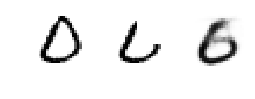

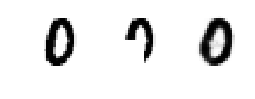

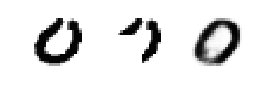

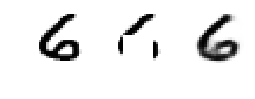

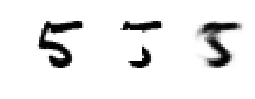

In [32]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)  # run the initializer
    train(sess, np.copy(train_data),valid_data,batch_size, n_epochs)
    test(sess,np.copy(x_test),test_data,batch_size)
    print_samples(sess, x_test, test_data,batch_size)


6. MNIST CLASSIFICATION - OPTIONAL

The presented in section 5. approach can be transfered to any type of FFN with ReLU activation. In this section we present a simple MNIST classification task on missing data. 

6.1. Set up hyperparameters

In [0]:
from sklearn.preprocessing import Imputer
# Training Parameters
learning_rate = 0.001
n_epochs = 40
batch_size = 64

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 256 # 2nd layer num features
num_hidden_3 = 64  # 128 # 3nd layer num features (the latent dim)
num_out = 10
num_input = 784  # MNIST data input (img shape: 28*28)

6.2. The accuracy function

In [0]:
def accuracy(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sum(y_true==y_pred)/len(y_true)

6.3. Set up a classical MNIST classification model. 

Ex. 12: Build a MNIST classification model. Use 3 hidden layers with ReLU activation on the first one and sigmoid activation on the subsequent layers. The dimensions of the hidden layers are given in section 6.1. Note that this is equal to the architecture of the encoder in sections 2. and 4.  

Define the loss and optimization operation. Create and fit the sklearn Imputer model. 

In [0]:
X = tf.placeholder(tf.float32, [None, num_input], name="P1" )
y = tf.placeholder(tf.int32, [None], name="P2")

labels = tf.one_hot(y, num_out)

from tensorflow.keras.layers import Dense

layer_1 = Dense(num_hidden_1, activation="relu")(X)
layer_2 = Dense(num_hidden_2, activation="sigmoid")(layer_1)
layer_3 = Dense(num_hidden_3, activation="sigmoid")(layer_2)
pred = Dense(num_out,activation=None)(layer_3)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits = pred))
optimizer_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# create an imputer from sklearn, which replace the missing values with the mean.
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(train_data)




6.4. Train the classfication model, imputing the missing values in the input using the `SimpleImputer`.

In [0]:
def train(sess, x_train, y_train, x_valid, y_valid, batch_size, n_epochs, imp):
    for epoch in range(1, n_epochs + 1):
        #train
        n_batches = x_train.shape[0] // batch_size
        train_loss = []
        for iteration in tqdm(range(n_batches)):
            
            # get the train batch
            batch_x = x_train[iteration * batch_size : (iteration+1) * batch_size, :]
            batch_y = y_train[iteration * batch_size : (iteration+1) * batch_size]
            batch_x = imp.transform(batch_x)
            _, l = sess.run([optimizer_op, loss],  feed_dict={X: batch_x, y:batch_y})
            train_loss.append(l)
    
        #valid
        valid_n_batches = x_valid.shape[0]//batch_size
        valid_loss = []
        for iteration in range(valid_n_batches):
            batch_valid_x = x_valid[iteration * batch_size : (iteration+1) * batch_size, :]
            batch_valid_y = y_valid[iteration * batch_size : (iteration+1) * batch_size]
            batch_valid_x = imp.transform(batch_valid_x)
            valid_loss.append(sess.run(loss,  feed_dict={X:batch_valid_x, y:batch_valid_y}))
        print('Step %i: Loss mean: %.8f Valid loss mean: %.8f' % (epoch, np.mean(train_loss), np.mean(valid_loss)))
        sys.stdout.flush()
        #shuffle the train dataset (dummy)
        idx = np.random.choice(len(x_train),len(x_train),replace=False)
        x_train = x_train[idx]
        y_train = y_train[idx]
    print('\n==========================')

6.5 Evaluate the model

In [0]:
import numpy as np
import sys
from tqdm import tqdm

def test(sess, x_test, y_test, batch_size, imp):
    train_loss = []
    acc = []
    # test
    n_batches = x_test.shape[0] // batch_size
    for iteration in tqdm(range(n_batches)):
        #print("\r{}% ".format(100 * (iteration + 1) // n_batches), end="")
        batch_x = x_test[iteration * batch_size : (iteration+1)*batch_size, :]
        batch_y = y_test[iteration * batch_size : (iteration+1)*batch_size]
        batch_x = imp.transform(batch_x)
        l, y_p = sess.run([loss,tf.nn.softmax(pred)], feed_dict={X:batch_x, y:batch_y})
        train_loss.append(l)
        acc.append(accuracy(batch_y, np.argmax(y_p,axis=1)))
        
   
    print('{}CROSS-ENTROPY for the test dataset: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['bold'], np.mean(train_loss), transform_write['end']))
    print('{}ACCURACY for the test dataset {}{:0.5f}{}'.format(transform_write['italic'], transform_write['red'] + transform_write['bold'],np.mean(acc), transform_write['end']))
   

6.6. Run the code:

In [0]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sys.stdout.flush()
    train(sess, np.copy(train_data), y_train, valid_data, y_valid, batch_size,n_epochs, imp)
    sys.stdout.flush()
    test(sess, np.copy(test_data), y_test, batch_size, imp)

6.7. Set up the model using the first layer from section 5.  

Ex. 13: Change the first layer to the layer defined in section 5. Other model parameters follow the definitions in 6.3

In [0]:

X = tf.placeholder(tf.float32, [None, num_input], name="P1" )
y = tf.placeholder(tf.int32, [None], name="P2")


labels = tf.one_hot(y, num_out)

# means, covs - means and covs of the GMM 
covs = tf.abs(covs)
p = tf.abs(p)
p = tf.div(p, tf.reduce_sum(p, axis=0))

layer_1 = first_layer(X, means, covs, p)
layer_2 = Dense(num_hidden_2, activation="sigmoid")(layer_1)
layer_3 = Dense(num_hidden_3, activation="sigmoid")(layer_2)
pred = Dense(num_out,activation=None)(layer_3)

#pred_soft = tf.nn.softmax(pred)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits = pred))
optimizer_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


6.8 Train the model.

In [0]:

def train(sess, x_train, y_train, x_valid, y_valid, batch_size, n_epochs):
    for epoch in range(1, n_epochs + 1):
        #train
        n_batches = x_train.shape[0] // batch_size
        train_loss = []
        for iteration in tqdm(range(n_batches)):
            # get the train batch
            batch_x = x_train[iteration * batch_size : (iteration+1) * batch_size, :]
            batch_y = y_train[iteration * batch_size : (iteration+1) * batch_size]
            #print(batch_x, batch_y)
            _, l = sess.run([optimizer_op, loss],  feed_dict={X: batch_x, y:batch_y})
            train_loss.append(l)
        #valid
        valid_n_batches = x_valid.shape[0]//batch_size
        valid_loss = []
        for iteration in range(valid_n_batches):
            batch_valid_x = x_valid[iteration * batch_size : (iteration+1) * batch_size, :]
            batch_valid_y = y_valid[iteration * batch_size : (iteration+1) * batch_size]
           
            valid_loss.append(sess.run(loss,  feed_dict={X:batch_valid_x, y:batch_valid_y}))
        print('Step %i: Loss mean: %.8f Valid loss mean: %.8f' % (epoch, np.mean(train_loss), np.mean(valid_loss)))
        sys.stdout.flush()
        idx = np.random.choice(len(x_train),len(x_train),replace=False)
        x_train = x_train[idx]
        y_train = y_train[idx]

    print('\n==========================')
    

6.9. Evaluate the model

In [0]:
def test(sess, x_test, y_test, batch_size):
    train_loss = []
    acc = []
    # test
    n_batches = x_test.shape[0] // batch_size
    for iteration in tqdm(range(n_batches)):
        #print("\r{}% ".format(100 * (iteration + 1) // n_batches), end="")
        batch_x = x_test[iteration * batch_size : (iteration+1)*batch_size, :]
        batch_y = y_test[iteration * batch_size : (iteration+1)*batch_size]
        l, y_p = sess.run([loss,tf.nn.softmax(pred)], feed_dict={X:batch_x, y:batch_y})
        train_loss.append(l)
        acc.append(accuracy(batch_y, np.argmax(y_p,axis=1)))
        
   
    print('{}CROSS-ENTROPY for the test dataset: {}{:0.5f}{}'.format(transform_write['italic'], transform_write['bold'], np.mean(train_loss), transform_write['end']))
    print('{}ACCURACY for the test dataset {}{:0.5f}{}'.format(transform_write['italic'], transform_write['red'] + transform_write['bold'],np.mean(acc), transform_write['end']))
   

6.10: Run the code:

In [0]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    sys.stdout.flush()
    train(sess, np.copy(train_data), y_train, valid_data, y_valid, batch_size, n_epochs)
    sys.stdout.flush()
    test(sess, np.copy(test_data), y_test, batch_size)